Noah Matos - November 22 - Analysis Report

Hypothesis: 
Tracks from Clairo’s album 'Charm' will have higher average valence and energy levels than tracks from 'Sling,'. This could contribute to the popularity of each album. Each album was released in July of their respective release years and I believe this makes them elligible for comparison as they are much different sounding albums

In [42]:
import urllib
import requests
import pandas as pd
import json
import base64
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf

In [43]:
def get_session_token(SessionID, SessionKey):
    url = 'https://accounts.spotify.com/api/token'
    data = {'grant_type':'client_credentials'}
    
    encoded_key = base64.b64encode(str(SessionID + ":" + SessionKey).encode("ascii"))
    
    header = {'Authorization': 'Basic {}'.format(encoded_key.decode("ascii"))}
    response = requests.post(url, 
                             data = data, 
                             headers = header)
   
    print(response.status_code)
    return response.json()['access_token']

function that outputs access token to access the api's

In [44]:
keys = pd.read_csv("/Users/noahmatos/dataEMAT_fa24/Spotify_Keys_9-19-24.txt")
#keys

In [45]:
#get_session_token(keys['Client_ID'].iloc[0], keys['Client_Secret'].iloc[0])

In [46]:
access_token = get_session_token(keys['Client_ID'].iloc[0], keys['Client_Secret'].iloc[0])
#access_token

200


In [47]:
t_features_ep = 'https://api.spotify.com/v1/audio-features'
albums_ep = 'https://api.spotify.com/v1/albums/{}'
tracks_ep = 'https://api.spotify.com/v1/tracks'
ab_tracks_ep = 'https://api.spotify.com/v1/albums/{}/tracks'

In [48]:
def api_call(endpoint_url, api_header):
    response = requests.get(endpoint_url, headers = api_header)
    print(response.status_code)
    return response.json()

this function allows me to pass through the endpoint i want and the session header in order to access the data in that endpoint

In [49]:
session_header = {'Authorization': 'Bearer {}'.format(access_token)}

In [50]:
sling_album_id = '32ium7Cxb1Xwp2MLzH2459'
charm_album_id = '1KNUCVXgIxKUGiuEB8eG0i'

this defines the album id's for each album to be passed through when using the api_call function

In [51]:
ab_tracks_ep.format(sling_album_id)

'https://api.spotify.com/v1/albums/32ium7Cxb1Xwp2MLzH2459/tracks'

In [52]:
ab_tracks_ep.format(charm_album_id)

'https://api.spotify.com/v1/albums/1KNUCVXgIxKUGiuEB8eG0i/tracks'

In [53]:
sling_album_response = api_call(ab_tracks_ep.format(sling_album_id),session_header)
charm_album_response = api_call(ab_tracks_ep.format(charm_album_id),session_header)

200
200


the album reponse variables allow me to access the album tracks endpoint and parse that data

going to be focusing on sling first

In [54]:
sling_album_response.keys()

dict_keys(['href', 'items', 'limit', 'next', 'offset', 'previous', 'total'])

In [55]:
sling_album_df = pd.DataFrame(sling_album_response['items'])
#sling_album_df.head()

In [56]:
charm_album_df = pd.DataFrame(charm_album_response['items'])
#charm_album_df.head()

intial untidy dataframes of each album tracks endpoint

In [57]:
sling_track_ids = ','.join(sling_album_df['id'].to_list())
charm_track_ids = ','.join(charm_album_df['id'].to_list())
sling_track_ids

'6wQXjA6KWbwPT3ydQCsJ4P,0HAqq2GcQKyi3s87GuN7jU,4iBtktPvH4yfS5LR6oAQT1,67bSS4aLrasUNp3EQjdHTT,7brBeAX3RT0CMh3qbTBrIP,6VyCMQf7wZyZF4j9368HGK,57VAuR1WgKFzcpO3ujQx9A,63O4CpEtppRmeOZ89Fb8tn,1bCFgapvqHqqcuQXgnP94L,2P0qa2otcQdjrnypyueuJl,3Gjj8LeMagv4Ou2p7kgQHT,6IemSJkHc0EHmGPRnxamG5'

puts the track ids of each album into a string list in order to pass through api_call

In [58]:
t_features_ep + '?ids={}'.format(sling_track_ids)
t_features_ep + '?ids={}'.format(charm_track_ids)

'https://api.spotify.com/v1/audio-features?ids=4WJPxTsvWIdRZ9vMtqk7fj,3awweDjWIuXNMogMClJnvE,7cFwopK7QTOgaEwF9JgipA,2qmmnbJ9JR3f7vofbyje5r,0mMlo76aVZHpuvoR6fjBSK,32fwe7MW5koort1Ua3YFx6,2mWfVxEo4xZYDaz0v7hYrN,6FcDxtnGfsYHOcGkXN2OIG,6QlSPjiXHc1XwGKeEls6Gh,4JLBaHFkjxnbf9X0D8G3zQ,3lnEcmIHlkeqcgDiZ5cgN3'

adds each track id to the track features endpoint in order for them all to be passed through to the api_call function, which is what i do next

In [59]:
sling_track_features = api_call(t_features_ep + '?ids={}'.format(sling_track_ids),
                             session_header)
charm_track_features = api_call(t_features_ep + '?ids={}'.format(charm_track_ids),
                             session_header)

200
200


passses track features and each track id through api_call in order to parse through the audio features data for each album

In [60]:
sling_features_df = pd.DataFrame(sling_track_features['audio_features'])
#sling_features_df

In [61]:
charm_features_df = pd.DataFrame(charm_track_features['audio_features'])
#charm_features_df

initial untidy dataframes of the track features of each album

In [62]:
sling_track_info = api_call(tracks_ep + '?market=US&ids={}'.format(sling_track_ids),
                             session_header)
charm_track_info = api_call(tracks_ep + '?market=US&ids={}'.format(charm_track_ids),
                             session_header)

200
200


In [63]:
sling_info_df = pd.DataFrame(sling_track_info['tracks'])
sling_info_df.head()

,album,artists,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,is_playable,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,277400,False,{'isrc': 'USUG12101890'},{'spotify': 'https://open.spotify.com/track/6w...,https://api.spotify.com/v1/tracks/6wQXjA6KWbwP...,6wQXjA6KWbwPT3ydQCsJ4P,False,True,Bambi,55,None,1,track,spotify:track:6wQXjA6KWbwPT3ydQCsJ4P
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,228922,False,{'isrc': 'USUG12101891'},{'spotify': 'https://open.spotify.com/track/0H...,https://api.spotify.com/v1/tracks/0HAqq2GcQKyi...,0HAqq2GcQKyi3s87GuN7jU,False,True,Amoeba,71,None,2,track,spotify:track:0HAqq2GcQKyi3s87GuN7jU
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,193677,False,{'isrc': 'USUG12101892'},{'spotify': 'https://open.spotify.com/track/4i...,https://api.spotify.com/v1/tracks/4iBtktPvH4yf...,4iBtktPvH4yfS5LR6oAQT1,False,True,Partridge,52,None,3,track,spotify:track:4iBtktPvH4yfS5LR6oAQT1
3,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,174765,False,{'isrc': 'USUG12101893'},{'spotify': 'https://open.spotify.com/track/67...,https://api.spotify.com/v1/tracks/67bSS4aLrasU...,67bSS4aLrasUNp3EQjdHTT,False,True,Zinnias,49,None,4,track,spotify:track:67bSS4aLrasUNp3EQjdHTT
4,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,195376,False,{'isrc': 'USUG12101894'},{'spotify': 'https://open.spotify.com/track/7b...,https://api.spotify.com/v1/tracks/7brBeAX3RT0C...,7brBeAX3RT0CMh3qbTBrIP,False,True,Blouse,54,None,5,track,spotify:track:7brBeAX3RT0CMh3qbTBrIP


In [64]:
charm_info_df = pd.DataFrame(charm_track_info['tracks'])
charm_info_df.head()

,album,artists,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,is_playable,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,225572,False,{'isrc': 'USA2P2416223'},{'spotify': 'https://open.spotify.com/track/4W...,https://api.spotify.com/v1/tracks/4WJPxTsvWIdR...,4WJPxTsvWIdRZ9vMtqk7fj,False,True,Nomad,66,https://p.scdn.co/mp3-preview/d7f0b59404db6116...,1,track,spotify:track:4WJPxTsvWIdRZ9vMtqk7fj
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,207795,False,{'isrc': 'USA2P2416224'},{'spotify': 'https://open.spotify.com/track/3a...,https://api.spotify.com/v1/tracks/3awweDjWIuXN...,3awweDjWIuXNMogMClJnvE,False,True,Sexy to Someone,72,https://p.scdn.co/mp3-preview/fd77356af12fe7e2...,2,track,spotify:track:3awweDjWIuXNMogMClJnvE
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,227409,False,{'isrc': 'USA2P2416225'},{'spotify': 'https://open.spotify.com/track/7c...,https://api.spotify.com/v1/tracks/7cFwopK7QTOg...,7cFwopK7QTOgaEwF9JgipA,False,True,Second Nature,66,https://p.scdn.co/mp3-preview/811adc83124d3dce...,3,track,spotify:track:7cFwopK7QTOgaEwF9JgipA
3,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,234853,False,{'isrc': 'USA2P2416226'},{'spotify': 'https://open.spotify.com/track/2q...,https://api.spotify.com/v1/tracks/2qmmnbJ9JR3f...,2qmmnbJ9JR3f7vofbyje5r,False,True,Slow Dance,67,https://p.scdn.co/mp3-preview/2897ab3e11a54e14...,4,track,spotify:track:2qmmnbJ9JR3f7vofbyje5r
4,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,205069,False,{'isrc': 'USA2P2416227'},{'spotify': 'https://open.spotify.com/track/0m...,https://api.spotify.com/v1/tracks/0mMlo76aVZHp...,0mMlo76aVZHpuvoR6fjBSK,False,True,Thank You,64,https://p.scdn.co/mp3-preview/9a4096a287e641a9...,5,track,spotify:track:0mMlo76aVZHpuvoR6fjBSK


this is the intial untidy dataframe for the track info of each album

next it is time to merge the two and tidy them up

In [65]:
sling_merged = pd.merge(sling_features_df, sling_info_df,
                        how = 'inner', on = 'id')
#sling_merged

merges the track features and track info dataframes of sling into one dataframe

In [66]:
charm_merged = pd.merge(charm_features_df, charm_info_df,
                        how = 'inner', on = 'id')
#charm_merged

merges the track features and track info dataframes of charm into one dataframe

In [67]:
sling_merged.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type_x', 'id', 'uri_x', 'track_href', 'analysis_url', 'duration_ms_x',
       'time_signature', 'album', 'artists', 'disc_number', 'duration_ms_y',
       'explicit', 'external_ids', 'external_urls', 'href', 'is_local',
       'is_playable', 'name', 'popularity', 'preview_url', 'track_number',
       'type_y', 'uri_y'],
      dtype='object')

In [68]:
sling_merged['albums'] = "Sling"
charm_merged['albums'] = "Charm"

adding an album distinguisher column because the 'album' property in the columns doesn't show up in the dataframe for reasons unknown to me

In [69]:
sling_merged.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type_x', 'id', 'uri_x', 'track_href', 'analysis_url', 'duration_ms_x',
       'time_signature', 'album', 'artists', 'disc_number', 'duration_ms_y',
       'explicit', 'external_ids', 'external_urls', 'href', 'is_local',
       'is_playable', 'name', 'popularity', 'preview_url', 'track_number',
       'type_y', 'uri_y', 'albums'],
      dtype='object')

In [70]:
albums_ep.format(sling_album_id)

'https://api.spotify.com/v1/albums/32ium7Cxb1Xwp2MLzH2459'

In [71]:
albums_ep.format(charm_album_id)

'https://api.spotify.com/v1/albums/1KNUCVXgIxKUGiuEB8eG0i'

these are the urls being passed into the api_call function in order to get the album data for each album

In [72]:
sling_release = api_call(albums_ep.format(sling_album_id),session_header)

200


allows me to parse through the data in the albums endpoint for sling

In [73]:
sling_release['release_date']

'2021-07-16'

In [74]:
charm_release = api_call(albums_ep.format(charm_album_id),session_header)

200


allows me to parse through the data in the albums endpoint for charm

In [75]:
charm_release['release_date']

'2024-07-12'

In [76]:
sling_merged['release_dates'] = sling_release['release_date']
charm_merged['release_dates'] = charm_release['release_date']

the 5 code blocks above allow me to access the albums endpoint to parse through and isolate the release date data

In [77]:
clairo_compare = pd.concat([sling_merged, charm_merged], axis = 0)
#clairo_compare

this merges the two dataframes for each album

In [78]:
clairo_compare_tidy = clairo_compare.drop(columns = ['type_y', 'is_local', 'is_playable', 'preview_url', 'mode'])
clairo_compare_tidy

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,explicit,external_ids,external_urls,href,name,popularity,track_number,uri_y,albums,release_dates
0,0.436,0.1960,9,-14.566,0.0284,0.904,0.002300,0.1070,0.2810,83.768,...,False,{'isrc': 'USUG12101890'},{'spotify': 'https://open.spotify.com/track/6w...,https://api.spotify.com/v1/tracks/6wQXjA6KWbwP...,Bambi,55,1,spotify:track:6wQXjA6KWbwPT3ydQCsJ4P,Sling,2021-07-16
1,0.739,0.4910,6,-11.515,0.0270,0.791,0.036600,0.1000,0.7070,111.008,...,False,{'isrc': 'USUG12101891'},{'spotify': 'https://open.spotify.com/track/0H...,https://api.spotify.com/v1/tracks/0HAqq2GcQKyi...,Amoeba,71,2,spotify:track:0HAqq2GcQKyi3s87GuN7jU,Sling,2021-07-16
2,0.666,0.1800,5,-17.015,0.0484,0.917,0.007810,0.1220,0.2650,130.021,...,False,{'isrc': 'USUG12101892'},{'spotify': 'https://open.spotify.com/track/4i...,https://api.spotify.com/v1/tracks/4iBtktPvH4yf...,Partridge,52,3,spotify:track:4iBtktPvH4yfS5LR6oAQT1,Sling,2021-07-16
3,0.695,0.4150,0,-13.489,0.0603,0.670,0.011100,0.3780,0.7790,145.982,...,False,{'isrc': 'USUG12101893'},{'spotify': 'https://open.spotify.com/track/67...,https://api.spotify.com/v1/tracks/67bSS4aLrasU...,Zinnias,49,4,spotify:track:67bSS4aLrasUNp3EQjdHTT,Sling,2021-07-16
4,0.324,0.1160,7,-20.332,0.0331,0.947,0.000286,0.1470,0.3990,144.524,...,False,{'isrc': 'USUG12101894'},{'spotify': 'https://open.spotify.com/track/7b...,https://api.spotify.com/v1/tracks/7brBeAX3RT0C...,Blouse,54,5,spotify:track:7brBeAX3RT0CMh3qbTBrIP,Sling,2021-07-16
5,0.606,0.1590,5,-18.181,0.0355,0.954,0.007360,0.1050,0.3330,107.792,...,False,{'isrc': 'USUG12101895'},{'spotify': 'https://open.spotify.com/track/6V...,https://api.spotify.com/v1/tracks/6VyCMQf7wZyZ...,Wade,47,6,spotify:track:6VyCMQf7wZyZF4j9368HGK,Sling,2021-07-16
6,0.380,0.1670,6,-15.294,0.0374,0.950,0.000369,0.0844,0.1950,93.112,...,False,{'isrc': 'USUG12101896'},{'spotify': 'https://open.spotify.com/track/57...,https://api.spotify.com/v1/tracks/57VAuR1WgKFz...,Harbor,54,7,spotify:track:57VAuR1WgKFzcpO3ujQx9A,Sling,2021-07-16
7,0.379,0.0405,3,-21.848,0.0329,0.920,0.000572,0.1050,0.3190,144.335,...,False,{'isrc': 'USUG12101897'},{'spotify': 'https://open.spotify.com/track/63...,https://api.spotify.com/v1/tracks/63O4CpEtppRm...,Just For Today,49,8,spotify:track:63O4CpEtppRmeOZ89Fb8tn,Sling,2021-07-16
8,0.416,0.0740,2,-20.010,0.0407,0.957,0.899000,0.1230,0.0476,121.240,...,False,{'isrc': 'USUG12101898'},{'spotify': 'https://open.spotify.com/track/1b...,https://api.spotify.com/v1/tracks/1bCFgapvqHqq...,Joanie,45,9,spotify:track:1bCFgapvqHqqcuQXgnP94L,Sling,2021-07-16
9,0.536,0.2240,6,-19.681,0.0496,0.863,0.039400,0.1110,0.6250,147.881,...,True,{'isrc': 'USUG12101899'},{'spotify': 'https://open.spotify.com/track/2P...,https://api.spotify.com/v1/tracks/2P0qa2otcQdj...,Reaper,50,10,spotify:track:2P0qa2otcQdjrnypyueuJl,Sling,2021-07-16


this tidies up the dataframe, removing any unneccessary or redundant data

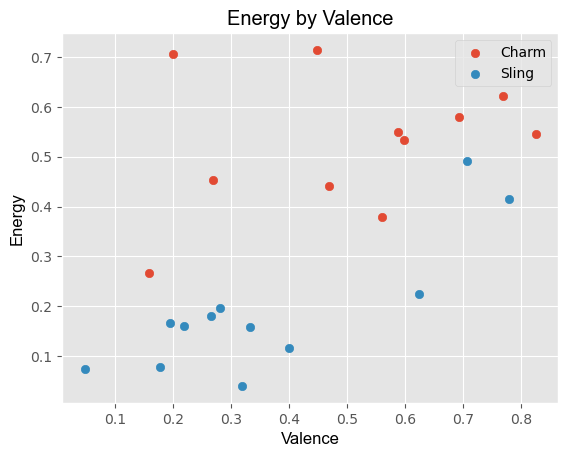

In [79]:
fig1, ax1 = plt.subplots()
ax1.scatter(charm_merged['valence'], charm_merged['energy'])
ax1.scatter(sling_merged['valence'], sling_merged['energy'])
csfont = {'fontname':'Arial'}
ax1.set_title('Energy by Valence', csfont)
ax1.set_xlabel('Valence', csfont, color = 'black')
ax1.set_ylabel('Energy', csfont, color = 'black')
ax1.legend(['Charm', 'Sling'])
plt.style.use('ggplot')
plt.show()

added 10/31/24

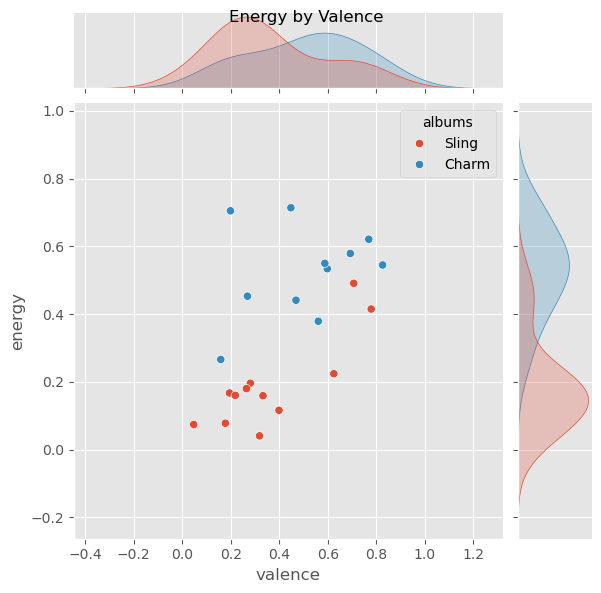

In [92]:
graph = sns.jointplot(data=clairo_compare_tidy, x="valence", y="energy", hue="albums")
graph.fig.suptitle("Energy by Valence")
graph

Through these visualizations we can clearly see that "Charm" has higher average "energy" and "valence levels. Let's further test if this affects the popularity.

In [104]:
fit1 = smf.ols('energy ~ popularity', data = clairo_compare_tidy).fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     53.00
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           3.61e-07
Time:                        15:42:00   Log-Likelihood:                 17.651
No. Observations:                  23   AIC:                            -31.30
Df Residuals:                      21   BIC:                            -29.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7233      0.150     -4.832      0.000      -1.035      -0.412
popularity     0.0183      0.003      7.280      0.000       0.013       0.023
==============================================================================
Omnibus:                        6.617   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                4.670
Skew:                           1.063   Prob(JB):                       0.0968
Kurtosis:                       3.593   Cond. No.                         364.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

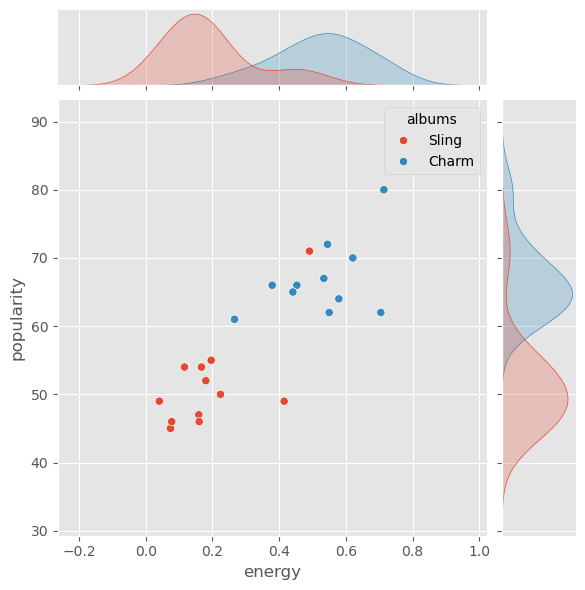

In [122]:
evp_graph = sns.jointplot(data=clairo_compare_tidy, x="energy", y="popularity", hue="albums")
graph.fig.suptitle("Popularity by Energy")
evp_graph

From the r-squared value of .716 and visualization above we can assume that energy has a decent, if not large, part to play on whether a song becomes popular. Next, valence.

In [105]:
fit2 = smf.ols('valence ~ popularity', data = clairo_compare_tidy).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     7.383
Date:                Wed, 20 Nov 2024   Prob (F-statistic):             0.0129
Time:                        15:43:11   Log-Likelihood:                 4.9458
No. Observations:                  23   AIC:                            -5.892
Df Residuals:                      21   BIC:                            -3.621
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2655      0.260     -1.021      0.319      -0.806       0.275
popularity     0.0118      0.004      2.717      0.013       0.003       0.021
==============================================================================
Omnibus:                        0.838   Durbin-Watson:                   2.656
Prob(Omnibus):                  0.658   Jarque-Bera (JB):                0.783
Skew:                           0.392   Prob(JB):                        0.676
Kurtosis:                       2.548   Cond. No.                         364.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

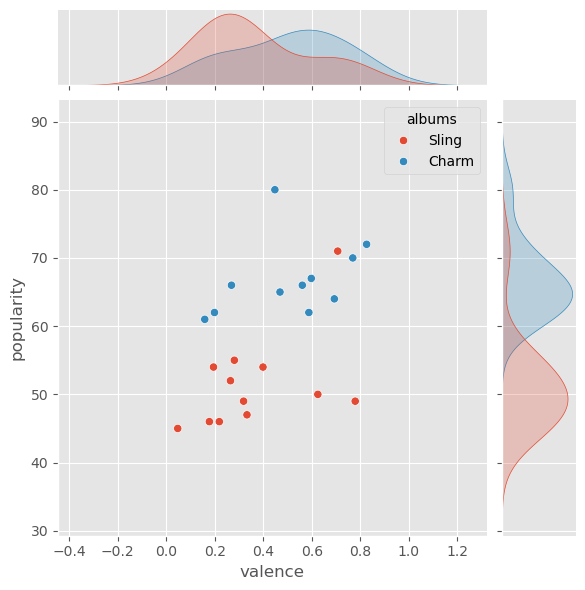

In [121]:
vvp_graph = sns.jointplot(data=clairo_compare_tidy, x="valence", y="popularity", hue="albums")
graph.fig.suptitle("Popularity by Valence")
vvp_graph

This summary has an r-squared value of .260 and both albums have similar valence levels. From this result we can tell that valence has less to do with how popular a song gets than energy.

From these visualizations, I am now able to conclude that, with room for some error, the level of energy in any one of these songs has a part to play in how popular the songs get.

Compared to the last submission, I actually had the skills to be able to visualize my assumptions and back them up. The valence levels of each album are very similar, but the energy levels show that "Charm" has a much higher result in that area. While valence may not play a large part in how popular a song gets, at least we know. If I possessed the skills to, the next step for me would be to compare both the energy and valence levels with the popularity of each album. This would probably be more of a 3D visualization that I do not currently have the skills to tackle at the moment.